In [0]:
# Por si alguien corre en python2
from __future__ import division

# Preparamos todo para correr
import numpy as np
from math import *
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import norm, binom, gamma, poisson, multivariate_normal
from sklearn import linear_model

import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.preprocessing as pp
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score




## Ejercicio 1:Fitteando una recta ruidosa de manera Bayesiana.

Como primer ejemplo de regresión lineal, tratemos de fittear los parametros $a_{0}$, $a_{1}$ de una recta $f(x,\vec{a}) = a_0 + a_{1}x$ donde $x$ está en el intervalo $[-1,1)$. Supongamos $a_{1} = 0.5$, $a_{0}= -0.3$.

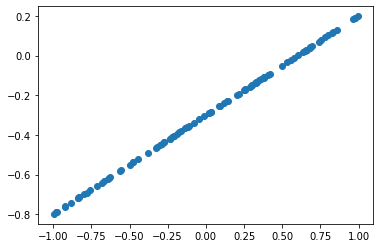

In [0]:
a1 = 0.5
a0 = -0.3
X = -1+2*np.random.rand(100)
f = a1*X+a0
plt.scatter(X,f)

Sin embargo, en un caso realista, las mediciones van a tener ruido. Este ruido puede modelarse como gaussiano, y lo asumimos con un $\sigma = 0.2$

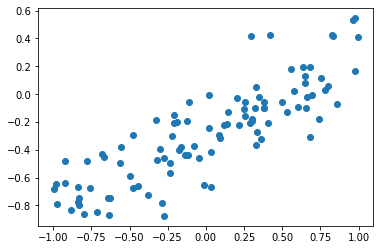

In [0]:
var = 0.2
T = f + norm.rvs(loc=0.0,scale=var,size=len(f))
plt.scatter(X,T)

Suponga que hacemos una regresión lineal de dos parametros, $w_{0}$, $w_{1}$. La regresión lineal implica que tenemos un estimador $y_{n}$ para $f_{n}$

$y_{n} = w_{0}+w_{1}x$

Luego, si asumimos errores gaussianos,

$p(t|x,\vec{w},\lambda) = \mathcal{N}(t|y(x,\vec{w}),\lambda^{-1})$

Entonces, aplicando el teorema de Bayes

$p(\vec{w}|t,x,\vec{\alpha})=\frac{p(t|x,\vec{w},\lambda,\vec{\alpha})p(\vec{w}|\vec{\alpha})}{p(t|x,\lambda,\vec{\alpha})}$

Donde $\vec{\alpha}$ es el vector de parametros del prior de $\vec{w}$ (asumimos conocida la varianza).

El caso más fácil es asumir el siguiente prior 

$p(\vec{w}|\alpha)=\mathcal{N}(\vec{w}|0,\alpha^{-1}\vec{1})$

Teniendo entonces que

$p(\vec{w}|t)=\mathcal{N}(\vec{w}|\vec{m}_{1},\text{S}_{1})$

Con $\vec{m}_{1} = \lambda \text{S}_{1}\Phi^{T}t$

Y $\text{S}^{-1}_{1} = \alpha \text{1} +\lambda \Phi^{T}\Phi$ 

Y $\Phi$ es la matriz que tiene dimensión $N_{\text{mediciones}}$x$N_{\text{parametros}}$. En este caso es una matriz de 1x2 con fila $(w_{0}, w_{1}x)$.

Esto no es otra cosa que decir que

$\text{ln}p(\vec{w}|t)=-\frac{\lambda}{2}(t-w_0-w_{1}x_{1})^{2}-\frac{\alpha}{2}(w^{2}_{0}+w^{1}_{0})$

Asumiendo algún $\alpha$ inicial, muestre como el posterior converge iterativamente. Grafique prior, verosimilitud y posterior para los primeros 3 pasos y para el paso 99. Además, grafique para cada paso la curva sampleada del punto de máxima probabilidad en el prior. Ya que estamos, para el primer paso muestre que recupera el caso analitico.

(50, 100)


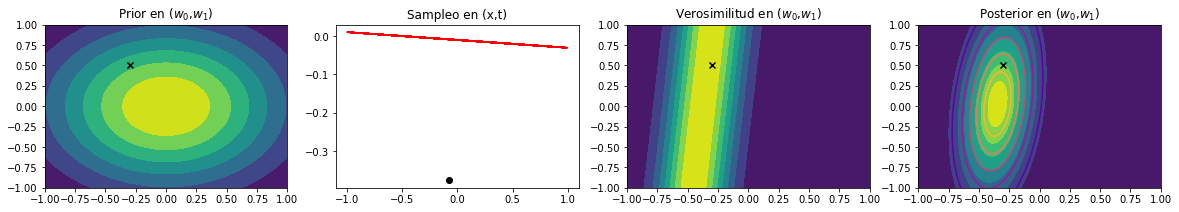

In [0]:
alpha=2.0
w0=np.linspace(-1,1,100)
w1=np.linspace(-1,1,50)
W0,W1 = np.meshgrid(w0,w1)#Este va a ser mi espacio para plottear.
W0.shape+(2,)
pos = np.empty(W0.shape + (2,))
pos[:, :, 0] = W0; pos[:, :, 1] = W1# esto me permite samplear un valor de mi prior para cada (w0,w1)

prior=multivariate_normal.pdf(pos,mean=np.zeros(2),cov=(1/alpha)*np.identity(2))#Sampleo mi prior
sampleo=[W0[np.where(prior==np.max(prior))][0],W1[np.where(prior==np.max(prior))][0]]#Elijo un maximo de mi prior. Como la normal es unimodal, es el unico maximo.
verosimilitud=norm.pdf(T[0],loc=W0+W1*X[0],scale=var)#para mi primer medicion, veo la verosimilitud
print(prior.shape)#verifico que ande todo bien
posterior_matrix=prior*verosimilitud
posterior_matrix=posterior_matrix/np.sum(posterior_matrix)

def posterior_proba_1(x,t,alpha,lam,w0,w1):#defini esta funcion para hacer todo analitico
  aux=-(lam/2)*(t-w0-w1*x)**2-(alpha/2)*(w0**2+w1**2)
  return np.exp(aux)
fig, axes = plt.subplots(1,4, figsize=(20,3))
axes[0].contourf(W0,W1,prior)
axes[0].scatter(a0,a1,marker='x',color='black')
axes[0].set_title('Prior en ($w_0$,$w_1$)')
#axes[0].set_xlabel(r'$w_0$')
#axes[0].set_ylabel(r'$w_1$')
axes[1].scatter(X[0],T[0],color='black')
axes[1].plot(X,sampleo[0]+sampleo[1]*X,color='red')
axes[1].set_title('Sampleo en (x,t)')
#axes[1].set_xlabel(r'$x$')
#axes[1].set_ylabel(r'$t$')
axes[2].contourf(W0,W1,verosimilitud)
axes[2].scatter(a0,a1,marker='x',color='black')
axes[2].set_title('Verosimilitud en ($w_0$,$w_1$)')
#axes[2].set_xlabel(r'$w_0$')
#axes[2].set_ylabel(r'$w_1$')
axes[3].contourf(W0,W1,posterior_matrix)
axes[3].scatter(a0,a1,marker='x',color='black')
axes[3].contour(W0,W1,posterior_proba_1(X[0],T[0],alpha,(1/var**2),W0,W1),cmap='plasma')
axes[3].set_title('Posterior en ($w_0$,$w_1$)')
#axes[3].set_xlabel(r'$w_0$')
#axes[3].set_ylabel(r'$w_1$')
fig.show()


In [0]:
prior_updating=[]
prior_updating.append(posterior_matrix)
posterior_updating=[]
for i in range(98):
  verosimilitud=norm.pdf(T[i+1],loc=W0+W1*X[i+1],scale=var)
  aux=np.asarray(verosimilitud)*np.asarray(prior_updating[-1])
  posterior_updating.append(aux/np.sum(aux))
  sampleo=[W0[np.where(prior_updating[-1]==np.max(prior_updating[-1]))][0],W1[np.where(prior_updating[-1]==np.max(prior_updating[-1]))][0]]
  #fig, axes = plt.subplots(1,4, figsize=(20,3))
  # axes[0].contourf(W0,W1,prior_updating[-1])
  # axes[0].scatter(a0,a1,marker='x',color='black')
  # axes[0].set_title('Prior en ($w_0$,$w_1$)')
  # axes[1].scatter(X[:i+2],T[:i+2],color='black')
  # axes[1].plot(X,sampleo[0]+sampleo[1]*X,color='red')
  # axes[1].set_title('Sampleo en (x,t)')
  # axes[2].contourf(W0,W1,verosimilitud)
  # axes[2].scatter(a0,a1,marker='x',color='black')
  # axes[2].set_title('Verosimilitud en ($w_0$,$w_1$)')
  # axes[3].contourf(W0,W1,posterior_updating[-1])
  # axes[3].scatter(a0,a1,marker='x',color='black')
  # axes[3].set_title('Posterior en ($w_0$,$w_1$)')
  # fig.show()
  prior_updating.append(posterior_updating[-1])

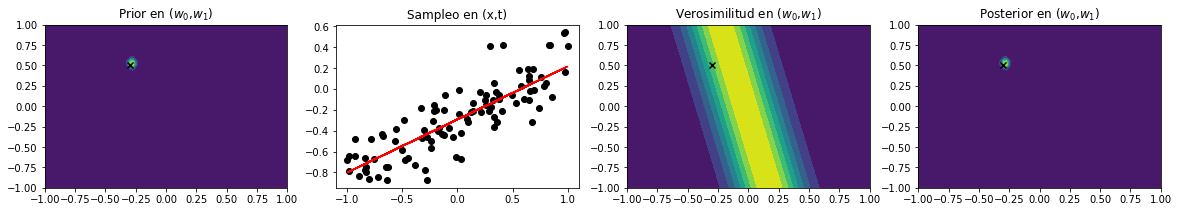

In [0]:
  fig, axes = plt.subplots(1,4, figsize=(20,3))
  axes[0].contourf(W0,W1,prior_updating[-1])
  axes[0].scatter(a0,a1,marker='x',color='black')
  axes[0].set_title('Prior en ($w_0$,$w_1$)')
  axes[1].scatter(X[:i+2],T[:i+2],color='black')
  axes[1].plot(X,sampleo[0]+sampleo[1]*X,color='red')
  axes[1].set_title('Sampleo en (x,t)')
  axes[2].contourf(W0,W1,verosimilitud)
  axes[2].scatter(a0,a1,marker='x',color='black')
  axes[2].set_title('Verosimilitud en ($w_0$,$w_1$)')
  axes[3].contourf(W0,W1,posterior_updating[-1])
  axes[3].scatter(a0,a1,marker='x',color='black')
  axes[3].set_title('Posterior en ($w_0$,$w_1$)')
  fig.show()

In [0]:
reg = linear_model.LinearRegression()
reg.fit(X.reshape(-1, 1),T)
print('Fitted (a0,a1) are (%8.3f,%8.3f) ' % (reg.intercept_,reg.coef_))

Fitted (a0,a1) are (  -0.283,   0.528) 


# Ejercicio 2: Algoritmo de Cuadrados Mínimos para encontrar la mejor superposición de funciones fijas


En el caso general en que yo tengo $\phi_{j}$ funciones de base <b>fijas</b> (con $j=0,1,..,M-1$) de manera tal que mi función $y(\vec{x},\vec{w})=\vec{w}^{T}\vec{\phi}(\vec{x})$ y asumo ruido Gaussiano, puedo modelar la verosimilitud del valor $t$ dado el input $\vec{x}$ como

$p(t|\vec{x},\vec{w},\lambda)=\mathcal{N}(t|\vec{w}^{T}\vec{\phi},\beta)$

En el que el valor esperado de t dado $\vec{x}$ es $y(\vec{x},\vec{w})$. Con este modelado, la función de error a minimizar, hallada al maximizar la verosimilitud, es la de cuadrados mínimos:

$E_{D}(\vec{w})=\frac{1}{2}(t-\vec{w}^{T}\vec{\phi}(\vec{x}))^{2}$

Donde aqui no aparece ningún otro término debido a que no se tiene en cuenta el aspecto bayesiano del problema.

En el caso de tener muchas mediciones $(\vec{x}_{i},t_i)$, el error a minimizar es:

$E_{D}(\vec{w})=\frac{1}{2}\sum_{i=1}^{N}(t_{i}-\vec{w}^{T}\vec{\phi}(\vec{x_{i}}))^{2} = \sum_{i} E_{i}$

Este problema tiene una solución cerrada que puede verse en la Ecuación (3.15) del Bishop.

Sin embargo, también es útil observar que el error en cada medición es indenpendiente de las otras mediciones. Esto puede utilizarse para un algoritmo secuencial de fitteo de los coeficientes $\vec{w}$. Si uno tiene los coeficientes en un paso $\tau$, entonces puede computar el gradiente del error $\nabla_{\vec{w}} E_{n}$ al incorporar la n-esima medición y actualizar los coeficientes:

$\vec{w}^{\tau+1}=\vec{w}^{\tau}-\eta\nabla E_{n}(\vec{w}^{\tau})$

Donde $\eta$ es el parametro de aprendizaje. Este es un ejemplo de algoritmo SGD y, aplicando la función de error de cuadrados mínimos, tenemos que

$\vec{w}^{\tau+1}=\vec{w}^{\tau}-\eta(t_{n}-\vec{w}^{\tau T}\vec{\phi}(\vec{x}_n))\vec{\phi}(\vec{x}_{n})$


a) Para el siguiente dataset, estudie la base de polinomios $\phi_{j}=x^{j}$ para distintos $M$: encuentre la solución cerrada y estudie la convergencia del método iterativo, vea la dependencia en el valor inicial $\vec{w}^{0}$ y $\eta$.

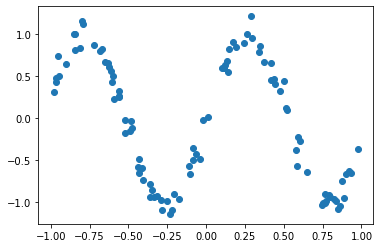

In [0]:
X=-1.0+2.0*np.random.rand(100)
T=np.asarray(list(map(lambda x: 1.0*np.sin(6*x)+1.0*norm.rvs(loc=0.0,scale=0.1),X)))
T.shape
plt.scatter(X,T)

In [0]:
def phi_f(x,m):
  return float(x**m)

def error_function(T,X,M,W):
  aux_1=0.0
  for n in range(len(T)):
    aux_2=0.0
    for m in range(M):
      aux_2+=W[m]*phi_f(X[n],m)
    aux_1+=(T[n]-aux_2)**2 ## muy inestable
  return 0.5*aux_1

def error_function_var(t,x,M,W):
  aux = 0.0
  for m in range(M):
    aux+=W[m]*phi_f(x,m)
  return (t-aux)*np.asarray([phi_f(x,m) for m in range(M)])

def solucion_cerrada(T,X,M):
  phi_m=np.zeros((len(T),M))
  for n in range(len(T)):
    for m in range(M):
      phi_m[n,m]=phi_f(X[n],m)
  phi_mt=phi_m.T
  phi_mdag=np.linalg.solve(np.dot(phi_mt,phi_m),np.identity(M))
  return np.dot(phi_mdag,np.dot(phi_mt,T))

M=8
Wexact=solucion_cerrada(T,X,M)
exact_pol=np.asarray(list(map(lambda x: [Wexact[i]*phi_f(x,i) for i in range(M)],X)))
exact_pol_sum=np.sum(exact_pol,axis=1)

In [0]:
print(Wexact.shape)
error_function_var(T[0],X[0],M,Wexact).shape

(8,)


(8,)

[ -0.04894022   5.67868731   0.44278036 -30.83743271  -0.85154745
  42.70362671   0.45230747 -17.93678806] [ 1.69112826e-02  6.18261889e+00  4.43353095e-01 -3.25687582e+01
 -2.48982914e+00  4.32816642e+01  2.40984061e+00 -1.70031260e+01]


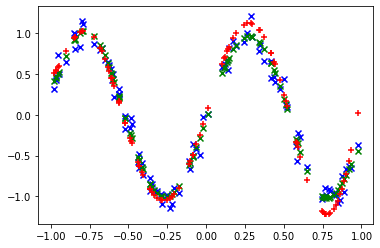

In [0]:
W0=Wexact-1*M+1*M*np.random.rand(M)
W=[]
W.append(W0)
errors=[]
errors.append(1000.0)

t0, t1 = 10, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)
for j in range(100):
  for i in range(int(len(X))):
    random_index = np.random.randint(int(len(X)))
    aux=error_function_var(T[random_index],X[random_index],M,W[-1])
    #print(aux)
    eta = learning_schedule(j * int(len(X)) + i)
    Wtry=W[-1]-eta*aux
    W.append(W[-1]+eta*aux)
    errors.append(error_function(T,X,M,W[-1]))



final_pol=np.asarray(list(map(lambda x: [W[-1][i]*(x**i) for i in range(M)],X)))
final_pol_sum=np.sum(final_pol,axis=1)

plt.scatter(X,T,color='blue',marker='x')
plt.scatter(X,exact_pol_sum,color='green',marker='x')
plt.scatter(X,final_pol_sum,color='red',marker='+')
print(Wexact,W[-1])


***
***

## Land, Land, Land https://www.youtube.com/watch?v=Nl9409NQPuU

Volvamos sobre un ejemplo práctico que utiliza modelos lineales para predecir el valor de casas en Boston.

Primero, exploremos un poco los datos.

In [2]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

# boston_dataset is a dictionary
# let's check what it contains

boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

boston['MEDV'] = boston_dataset.target

print(boston_dataset.keys())
print(boston.head())
keys=np.asarray(boston.keys())
print(boston.isnull().sum())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
      CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  MEDV
0  0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33  36.2

[5 rows x 14 columns]
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


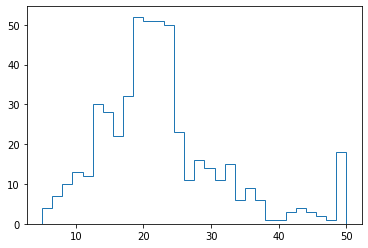

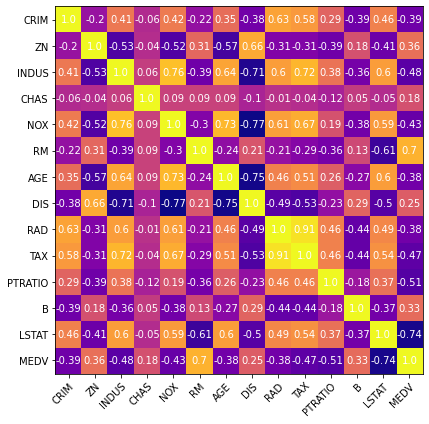

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b6a5db7b8>,
      dtype=object)

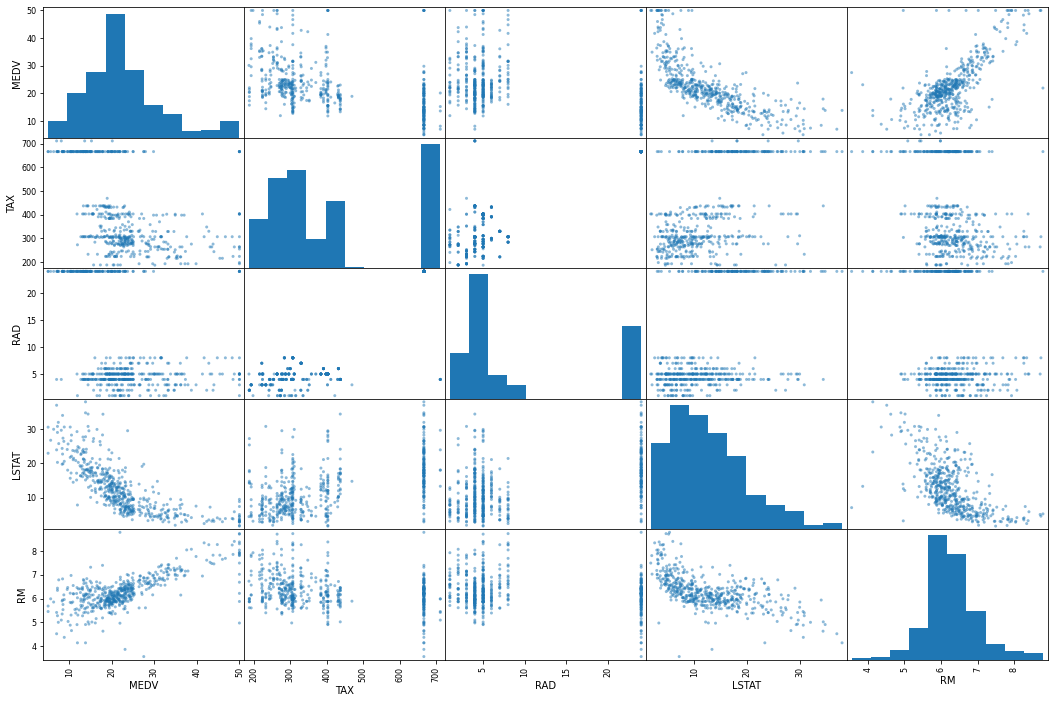

In [3]:
# plot a histogram showing the distribution of the target values
plt.hist(boston['MEDV'], bins=30,histtype='step')
plt.show()

correlation_matrix = np.asarray(boston.corr().round(2))
fig, ax = plt.subplots(figsize=((8,6)))
im = ax.imshow(correlation_matrix,cmap='plasma')
# # We want to show all ticks...
ax.set_xticks(np.arange(len(keys)))
ax.set_yticks(np.arange(len(keys)))
# # ... and label them with the respective list entries
ax.set_xticklabels(keys)
ax.set_yticklabels(keys)

# # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
for i in range(len(keys)):
    for j in range(len(keys)):
        text = ax.text(j, i, correlation_matrix[i, j],ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

attributes = ["MEDV","TAX", "RAD",'LSTAT', 'RM']
scatter_matrix(boston[attributes], figsize=(18, 12))

Ahora, separemos en train y test

In [0]:
train_set, test_set = train_test_split(boston, test_size=0.2, random_state=0)

#Train

boston_train = train_set.drop("MEDV", axis=1) # drop labels for training set
#housing_num=strat_train_set["total_rooms"].copy().reshape(-1, 1)
boston_labels = train_set["MEDV"].copy()

LSTAT_train=boston_train["LSTAT"].to_numpy()
LSTAT_train=LSTAT_train.reshape((len(LSTAT_train),1))

RM_train=boston_train["RM"].to_numpy()
RM_train=RM_train.reshape((len(RM_train),1))

two_var_train=boston_train[["LSTAT","RM"]]

#Test

boston_test = test_set.drop("MEDV", axis=1) # drop labels for test set
boston_test_labels = test_set["MEDV"].copy()


LSTAT_test=boston_test["LSTAT"].to_numpy()
LSTAT_test=LSTAT_test.reshape((len(LSTAT_test),1))

RM_test=boston_test["RM"].to_numpy()
RM_test=RM_test.reshape((len(RM_test),1))

two_var_test=boston_test[["LSTAT","RM"]]

Debo comparar:

* Regresión lineal unidimensional utilizando cada uno de los features escogidos.
* Regresión lineal bidimensional utilizando ambos features.
* Regresión polinomial cuadrática unidimensional utilizando cada uno de los features escogidos.
* Regresión polinomial cuadrática  bidimensional utilizando ambos features.

Para cada uno, hago validacion cruzada. Tengo 6 modelos a utilizar

([<matplotlib.axis.XTick at 0x7f5b69e1e6d8>,
 [Text(0, 0, 'LSTAT M = 1'),
  Text(0, 0, 'RM M = 1'),
  Text(0, 0, 'LSTAT + RM M = 1'),
  Text(0, 0, 'LSTAT M = 2'),
  Text(0, 0, 'RM M = 2'),
  Text(0, 0, 'LSTAT + RM M = 2')])

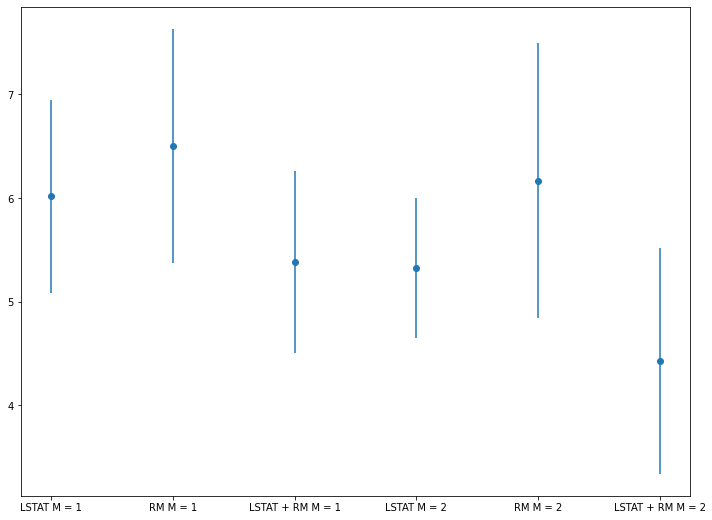

In [5]:
cv=10
modelos=np.arange(0,6,1)
labels=['LSTAT M = 1', 'RM M = 1', 'LSTAT + RM M = 1','LSTAT M = 2', 'RM M = 2', 'LSTAT + RM M = 2']
scores_mean=np.zeros(len(labels))
scores_std=np.zeros(len(labels))

lin_reg_aux = LinearRegression()
scores_aux=cross_val_score(lin_reg_aux, LSTAT_train, boston_labels, cv=cv, scoring='neg_root_mean_squared_error')
scores_mean[0]=(-scores_aux).mean()
scores_std[0]=(-scores_aux).std()

lin_reg_aux = LinearRegression()
scores_aux=cross_val_score(lin_reg_aux, RM_train, boston_labels, cv=cv, scoring='neg_root_mean_squared_error')
scores_mean[1]=(-scores_aux).mean()
scores_std[1]=(-scores_aux).std()

lin_reg_aux = LinearRegression()
scores_aux=cross_val_score(lin_reg_aux, two_var_train, boston_labels, cv=cv, scoring='neg_root_mean_squared_error')
scores_mean[2]=(-scores_aux).mean()
scores_std[2]=(-scores_aux).std()

#Y para el bidimensional unicamente debo hacer esto

polyfeat = pp.PolynomialFeatures(degree=2)

lin_reg_aux = LinearRegression()
scores_aux=cross_val_score(lin_reg_aux,polyfeat.fit_transform(LSTAT_train), boston_labels, cv=cv, scoring='neg_root_mean_squared_error')
scores_mean[3]=(-scores_aux).mean()
scores_std[3]=(-scores_aux).std()

lin_reg_aux = LinearRegression()
scores_aux=cross_val_score(lin_reg_aux, polyfeat.fit_transform(RM_train), boston_labels, cv=cv, scoring='neg_root_mean_squared_error')
scores_mean[4]=(-scores_aux).mean()
scores_std[4]=(-scores_aux).std()

lin_reg_aux = LinearRegression()
scores_aux=cross_val_score(lin_reg_aux, polyfeat.fit_transform(two_var_train), boston_labels, cv=cv, scoring='neg_root_mean_squared_error')
scores_mean[5]=(-scores_aux).mean()
scores_std[5]=(-scores_aux).std()
fig=plt.figure(figsize=((12,9)))
plt.errorbar(modelos, scores_mean, scores_std, fmt='o')
plt.xticks(np.arange(6), labels)

Ahora elijo un modelo

Test Absolute Differences
Max 27.63794314059802
Median 2.3453017545261075
25th-percentile 1.204483554242794
75th-percentile 4.073188428004043
90th-percentile 6.418975998367452 

RMSE (test) 5.305183490052328
MAE (test) 3.341518249180773


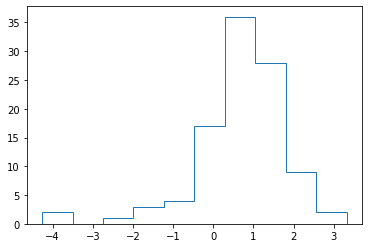

In [6]:
lin_reg_BEST=LinearRegression()
lin_reg_BEST.fit(polyfeat.fit_transform(two_var_train), boston_labels)

boston_test_predictions = lin_reg_BEST.predict(polyfeat.fit_transform(two_var_test))

abserror = np.abs(boston_test_predictions - boston_test_labels)
print('Test Absolute Differences')
print('Max', abserror.max())
print('Median', np.median(abserror))
print('25th-percentile', np.percentile(abserror, 25))
print('75th-percentile', np.percentile(abserror, 75))
print('90th-percentile', np.percentile(abserror, 90), '\n')

lin_mse = mean_squared_error(boston_test_labels, boston_test_predictions)
print('RMSE (test)', np.sqrt(lin_mse))
print('MAE (test)', mean_absolute_error(boston_test_labels, boston_test_predictions))

h = plt.hist(np.log(abserror), 10, histtype='step',label="LSTAT M = 1")

*C)* Considere la regresión polinomial  cuadrática de los ultimos dos casos. Añada un término de regularización LASSO y RIDGE. Utilice validación cruzada para medir su desempeño, ¿cómo se compara a los casos anteriores? ¿Puede elegir los valores óptimos para la regularización?

In [0]:
# Yo directamente armo una funcion que hace el modelado para un numero arbitrario de polinomios y de alphas. Encuentra el mejor alpha y con eso hace la cross validation

alphas = np.logspace(-20, -5, 25, base=np.e)
grados_pol=np.arange(2,3,1)
numbering=np.arange(0,6,1)

def cv_multimodel(x,t,Ridge_T,grados=grados_pol, alphas=alphas,cv=10, plot=False):
        
    rsmes = np.zeros(len(grados))
    std_rsmes = np.zeros(len(grados))
    modelos=[]
    for i, grado in enumerate(grados):
        polyfeat = pp.PolynomialFeatures(degree=grado)
        phi = polyfeat.fit_transform(x)
        if Ridge==True:
        # Regresión con Ridge haciendo CV en el hiperparámetro alpha
          ridgecv = RidgeCV(alphas=alphas, cv=cv, scoring='neg_root_mean_squared_error')
          ridgecv = ridgecv.fit(phi,t)
          modelos.append(ridgecv)
          modelo_ridge = Pipeline([('features', pp.PolynomialFeatures(degree=grado)),
                             ('regression', Ridge(alpha=ridgecv.alpha_))
                              ])
          scores = cross_val_score(modelo_ridge, x, t, cv=cv, scoring='neg_root_mean_squared_error')
        else:
        # Regresión con Lasso haciendo CV en el hiperparámetro alpha
          lassocv = LassoCV(alphas=alphas, cv=cv,tol=1e-3, max_iter=10000)
          lassocv = lassocv.fit(phi,t)
          modelos.append(lassocv)
          modelo_lasso = Pipeline([('features', pp.PolynomialFeatures(degree=grado)),
                             ('regression', Lasso(alpha=lassocv.alpha_, tol=1e-3, max_iter=10000))
                              ])
          scores = cross_val_score(modelo_lasso, x, t, cv=cv, scoring='neg_root_mean_squared_error')

        rsmes[i] = (-scores).mean()
        std_rsmes[i] = (-scores).std()
        if plot:
          fig2 = plt.figure()
          plt.scatter(t,lassocv.predict(phi))
          plt.scatter(t,t)
          fig2.show()
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # Sin errores
#        ax.semilogy(grados, rsmes, 'o', mfc='None')
        
        # Con errores
        ax.errorbar(grados, rsmes, std_rsmes, fmt='o')
        ax.set_yscale('log')
        
        ax.set_xlabel('Grado')
        ax.set_ylabel('mean RMSE')
                
    return grados, rsmes, std_rsmes, modelos

Ahora lo hago para el caso de M=2. Tengo 6 casos a considerar: LSTAT M=2 + RIDGE/LASSO, RM M=2 + RIDGE/LASSO, LSTAT+RM M=2 + RIDGE/LASSO, 

In [0]:
labels=['LSTAT M = 2 LASSO', 'LSTAT M = 2 RIDGE', 'RM M = 2 LASSO', 'RM M = 2 RIDGE','LSTAT+RM M = 2 LASSO', 'LSTAT+RM M = 2 RIDGE']
scores_mean=np.zeros(len(labels))
scores_std=np.zeros(len(labels))

grados, errors, errorst, modelos = cv_multimodel(LSTAT_train,boston_labels,Ridge_T=False);
scores_mean[0]=errors[0]
scores_std[0]=errorst[0]

grados, errors, errorst, modelos = cv_multimodel(LSTAT_train,boston_labels,Ridge_T=True);
scores_mean[1]=errors[0]
scores_std[1]=errorst[0]

grados, errors, errorst, modelos = cv_multimodel(RM_train,boston_labels,Ridge_T=False);
scores_mean[2]=errors[0]
scores_std[2]=errorst[0]

grados, errors, errorst, modelos = cv_multimodel(RM_train,boston_labels,Ridge_T=True);
scores_mean[3]=errors[0]
scores_std[3]=errorst[0]

grados, errors, errorst, modelos = cv_multimodel(two_var_train,boston_labels,Ridge_T=False);
scores_mean[4]=errors[0]
scores_std[4]=errorst[0]

grados, errors, errorst, modelos = cv_multimodel(two_var_train,boston_labels,Ridge_T=True);
scores_mean[5]=errors[0]
scores_std[5]=errorst[0]

([<matplotlib.axis.XTick at 0x7f5b68a13208>,
 [Text(0, 0, 'LSTAT M = 2 LASSO'),
  Text(0, 0, 'LSTAT M = 2 RIDGE'),
  Text(0, 0, 'RM M = 2 LASSO'),
  Text(0, 0, 'RM M = 2 RIDGE'),
  Text(0, 0, 'LSTAT+RM M = 2 LASSO'),
  Text(0, 0, 'LSTAT+RM M = 2 RIDGE')])

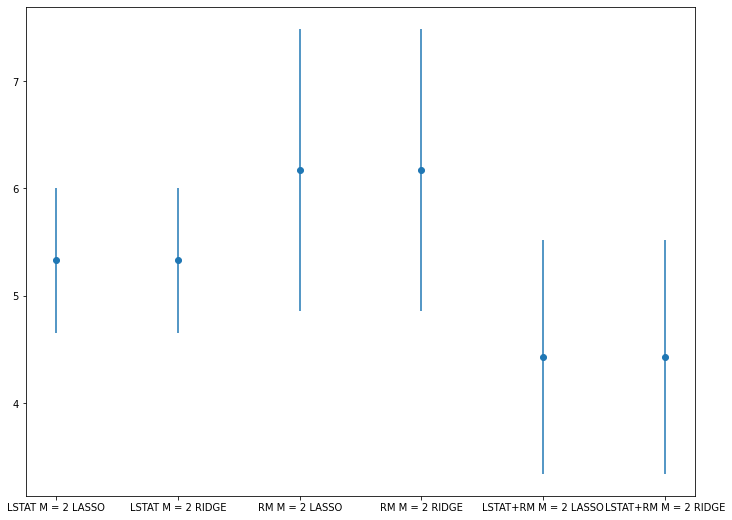

In [13]:
fig=plt.figure(figsize=((12,9)))
plt.errorbar(numbering, scores_mean, scores_std, fmt='o')
plt.xticks(np.arange(6), labels)